# Constructing linear models of firing rates with respect to velocity and duration

In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:

# here load rate_cat using numpy.load with allow_pickle=True
path_data = '../../data/processed'
date_data = '20250529'
spike_cat = np.load(f'{path_data}/spike_cat_{date_data}.npz', allow_pickle=True)['spike_cat']
vel_cat = np.load(f'{path_data}/vel_cat_{date_data}.npz', allow_pickle=True)['vel_cat']
dur_cat = np.load(f'{path_data}/dur_cat_{date_data}.npz', allow_pickle=True)['dur_cat']

In [53]:

rate_cat = []
for spike1 in spike_cat:
    rate1 = []
    for spike1_per_angle in spike1:
        # filter spike1_per_angle with gaussian_filter1d
        rate2 = 1e3*gaussian_filter1d(spike1_per_angle.astype(float), sigma=6, axis=1)
        rate1.append(rate2[:,50:-50])
    rate_cat.append(rate1)

In [54]:
pv_cat = []
for a in range(np.shape(vel_cat)[0]):
    M = []
    for ori in range(8):
        temp = vel_cat[a][ori]
        M.append(np.max(temp,axis = 1)*1e-3)
        # pv_cat[a][ori]  = np.max(temp,axis = 1)
    pv_cat.append(M)

pv_cat = np.array(pv_cat, dtype = object)

### Here we compute the statistics of kinematic parameters

In [55]:
pv_all = np.empty(0)
for session in pv_cat:
    for ori in session:
        pv_all = np.hstack((pv_all, ori))

av_all = np.empty(0)
for session in dur_cat:
    for ori in session[:8]:
        av_all = np.hstack((av_all, 10/ori))

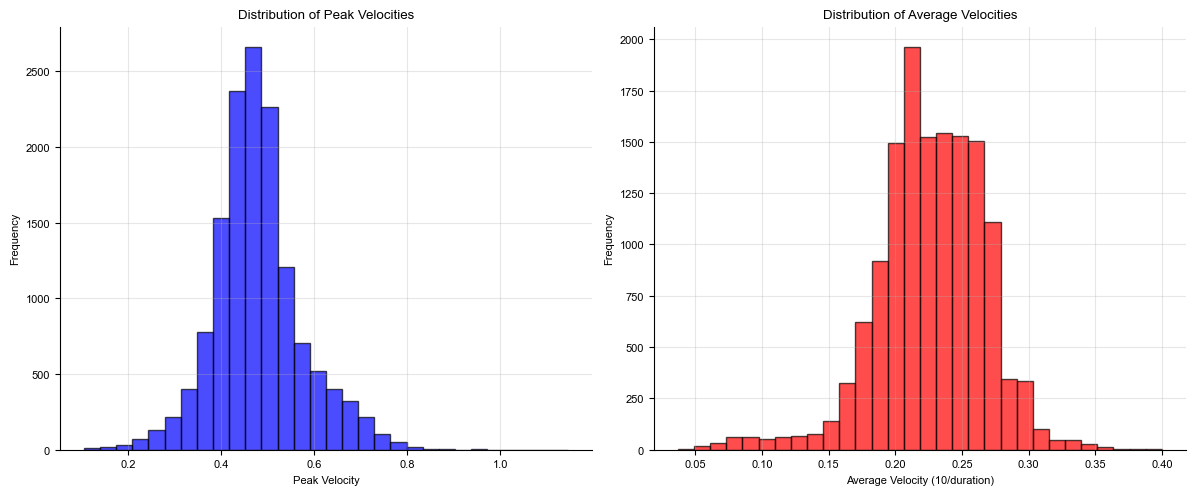

Peak Velocity: 0.47885947 ± 0.09520212
Average Velocity: 0.22651465 ± 0.04065501


In [56]:
# plot the histogram of pv_all and av_all side by side
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram of peak velocities
ax1.hist(pv_all, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Peak Velocity')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Peak Velocities')
ax1.grid(True, alpha=0.3)

# Plot histogram of average velocities
ax2.hist(av_all, bins=30, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Average Velocity (10/duration)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Average Velocities')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

pv0 = np.nanmean(pv_all)
av0 = np.nanmean(av_all)

sd_pv = np.std(pv_all)
sd_av = np.std(av_all)

# print all the statistics of pv_all and av_all mean+-sd form
print(f"Peak Velocity: {pv0:.8f} ± {sd_pv:.8f}")
print(f"Average Velocity: {av0:.8f} ± {sd_av:.8f}")



In [57]:
from sklearn.linear_model import LinearRegression

def create_av_pv_model(pv_all, av_all, pv_center=0.48, pv_range=0.1):
    """
    Create a linear model to predict AV based on PV with constrained data range.

    Parameters:
    - pv_all: Array of all peak velocity values
    - av_all: Array of all average velocity values
    - pv_center: Center value for PV range constraint (default: 0.48)
    - pv_range: Range around center to include (default: 0.1)

    Returns:
    - model: Fitted linear regression model
    - slope: Linear relationship slope
    - intercept: Linear relationship intercept
    - r_squared: Model performance metric
    """

    # Define the constrained range for PV
    pv_min = pv_center - pv_range  # 0.48 - 0.1 = 0.38
    pv_max = pv_center + pv_range  # 0.48 + 0.1 = 0.58

    # Filter data to only include values within the specified PV range
    mask = (pv_all >= pv_min) & (pv_all <= pv_max)
    pv_filtered = pv_all[mask]
    av_filtered = av_all[mask]

    # Remove any NaN values
    valid_mask = ~(np.isnan(pv_filtered) | np.isnan(av_filtered))
    pv_clean = pv_filtered[valid_mask]
    av_clean = av_filtered[valid_mask]

    print(f"Using {len(pv_clean)} data points from range [{pv_min:.2f}, {pv_max:.2f}]")
    print(f"Original dataset size: {len(pv_all)}")

    # Fit linear regression model
    model = LinearRegression()
    X = pv_clean.reshape(-1, 1)  # Reshape for sklearn
    y = av_clean

    model.fit(X, y)

    # Get model parameters
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    print(f"Linear relationship: AV = {slope:.6f} * PV + {intercept:.6f}")
    print(f"R-squared: {r_squared:.6f}")

    return model, slope, intercept, r_squared

def predict_av_from_pv(pv, model):
    """
    Predict AV given PV based on the linear relationship.

    Parameters:
    - pv: Peak velocity value(s) to predict for
    - model

    Returns:
    - av_predicted: Predicted average velocity value(s)
    """
    av_predicted = model.coef_[0] * pv + model.intercept_
    return av_predicted

def dur_from_pv(pv, model):
    return 10/predict_av_from_pv(pv, model)

model_av, _, _, _ = create_av_pv_model(pv_all, av_all, pv_range=0.15)



Using 12357 data points from range [0.33, 0.63]
Original dataset size: 14031
Linear relationship: AV = 0.332865 * PV + 0.071015
R-squared: 0.396724


Text(0.5, 1.0, 'var_pv = 0.00906344, var_av = 0.00165283, cov_pv_av = 0.00260781')

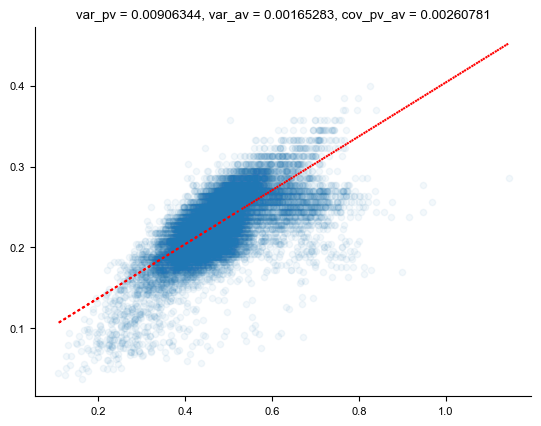

In [58]:
plt.scatter(pv_all, av_all, 20, alpha=0.05)
plt.plot(pv_all, predict_av_from_pv(pv_all, model_av), ':r')
plt.title(f'var_pv = {np.var(pv_all):.8f}, var_av = {np.var(av_all):.8f}, cov_pv_av = {np.cov(pv_all, av_all)[0,1]:.8f}')

In [59]:
pv_all.shape

(14031,)

With this we compute the linear models. We begin with a single parameter 

## 

In [60]:
import cbmanifold as cbm
from cbmanifold.linear_model import LinearModel

p0 = np.array([pv0])

lms = []
for i, pvs in tqdm(enumerate(pv_cat)):
    for ori, pv1 in enumerate(pvs):
        rate1 = rate_cat[i][ori]
        lm = cbm.linear_model.generate_linear_model(f'fn_{i}_{ori}', rate1, pv1[:,None], p0, output_type='dict')
        lms.append(lm)


0it [00:00, ?it/s]

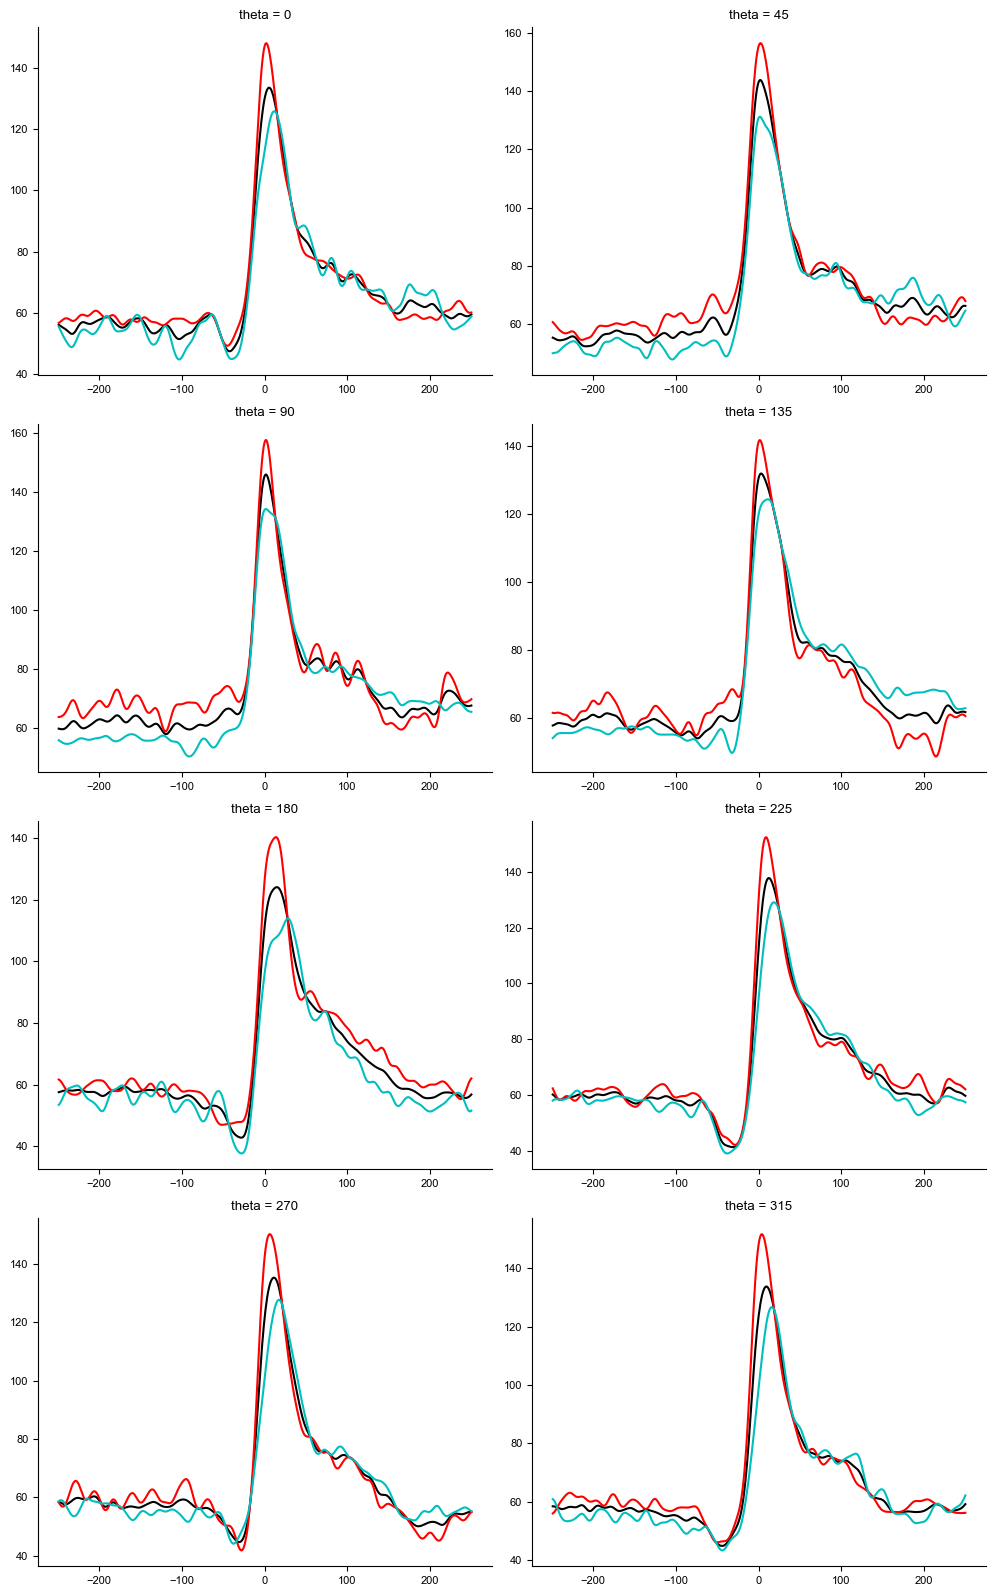

In [61]:
tt = np.arange(-249, 251)

fig, axes = plt.subplots(4, 2, figsize=(10, 16))
axes = axes.flatten()

for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr = np.vstack([lm['drate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])

    axes[ori].plot(tt, r0.mean(axis=0), 'k')
    axes[ori].plot(tt, (r0+dr*.100).mean(axis=0), 'r')
    axes[ori].plot(tt, (r0-dr*.100).mean(axis=0), 'c')
    axes[ori].set_title(f'theta = {45*ori}')

plt.tight_layout()
plt.show()



In [62]:
lmfn0s = []
for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr = np.vstack([lm['drate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    lm0 = LinearModel('fn_raw', rate=r0, drate=dr, params0=p0)
    lm0.ori = ori
    lm0.n_params = 1
    lmfn0s.append(lm0)

lmfn1s = []
for ori in range(8):
    r0 = lmfn0s[ori].rate
    dr = lmfn0s[ori].drate
    r0_nobase = r0 - (r0[:,:100].mean(axis=-1))[:,None]
    lm1 = LinearModel('fn_nobase', rate=r0_nobase, drate=dr, params0=p0)
    lm1.ori = ori
    lm1.n_params = 1
    lmfn1s.append(lm1)

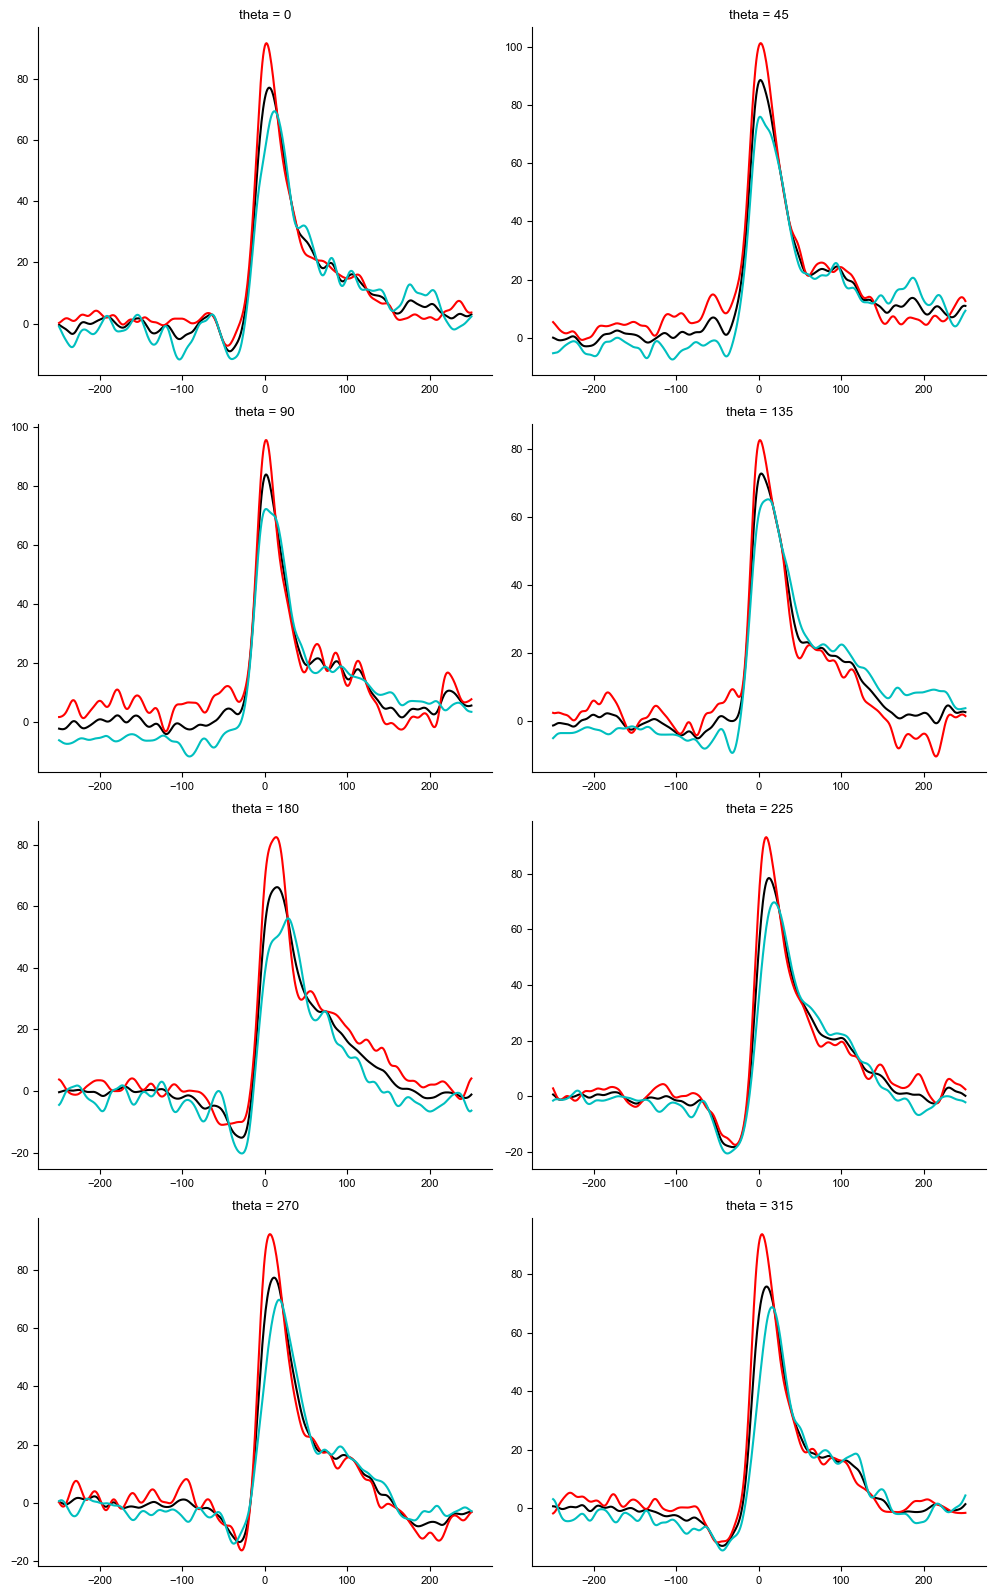

In [63]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16))
axes = axes.flatten()

for ori in range(8):
    lm = lmfn1s[ori]
    r0 = lm.rate
    dr = lm.drate

    axes[ori].plot(tt, r0.mean(axis=0), 'k')
    axes[ori].plot(tt, (r0+dr*.100).mean(axis=0), 'r')
    axes[ori].plot(tt, (r0-dr*.100).mean(axis=0), 'c')
    axes[ori].set_title(f'theta = {45*ori}')

plt.tight_layout()
plt.show()


Dimensions: 1, Variance explained: 61.43552217473173
Dimensions: 2, Variance explained: 70.79977689207193
Dimensions: 3, Variance explained: 77.1621564682111
Dimensions: 4, Variance explained: 81.3169762377338
Dimensions: 5, Variance explained: 84.72299697175897
Dimensions to be reduced: 6
Dimensions: 1, Variance explained: 59.46438492182343
Dimensions: 2, Variance explained: 76.12765764900789
Dimensions: 3, Variance explained: 82.62940096324779
Dimensions: 4, Variance explained: 86.53766859064217
Dimensions: 5, Variance explained: 89.66082834726019
Dimensions to be reduced: 5
Dimensions: 1, Variance explained: 49.54445483617309
Dimensions: 2, Variance explained: 71.87047886857718
Dimensions: 3, Variance explained: 79.4821467034307
Dimensions: 4, Variance explained: 84.48652658667356
Dimensions: 5, Variance explained: 86.73156151983494
Dimensions to be reduced: 6
Dimensions: 1, Variance explained: 57.623610368687
Dimensions: 2, Variance explained: 75.05075582690256
Dimensions: 3, Varia

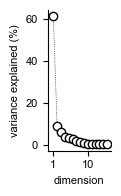

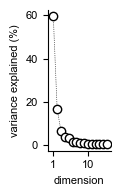

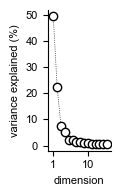

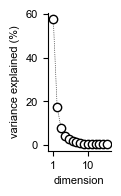

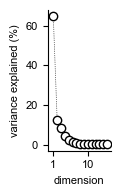

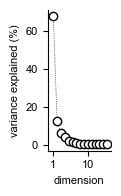

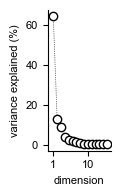

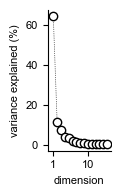

In [64]:
from cbmanifold.decomposition import pmPCA

# dds = np.empty()

for n in range(8):
    dd, p, v = pmPCA(lmfn1s[n].rate)
    var_explained = dd/np.sum(dd)*1e2;
    var_explained_cumsum = np.cumsum(var_explained);
    for i in range(5):
        print(f'Dimensions: {i+1}, Variance explained: {var_explained_cumsum[i]}')

    nmode = np.where(var_explained_cumsum > 87.5)[0][0]+1
    print(f'Dimensions to be reduced: {nmode}')

    _ = cbm.plot.plot_var_explained(var_explained)


In [65]:
d0 =     int(dur_from_pv(pv0, model_av))
dplus =  int(dur_from_pv(pv0+0.08, model_av))
dminus = int(dur_from_pv(pv0-0.08, model_av))
print(f'd0 = {d0}, dplus = {dplus}, dminus = {dminus}')


d0 = 43, dplus = 38, dminus = 49


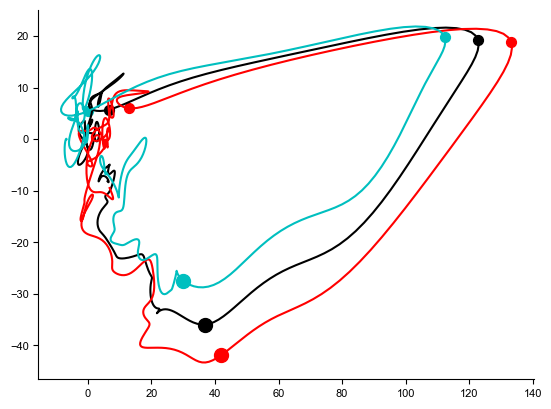

In [66]:
lmr = cbm.decomposition.reduce_dimensionality(lmfn1s[1], 4)
lmr = cbm.utils.flip_sign(lmr, [0,2]) # flip signs to make the cycles go CCW
plt.plot(lmr.p[0,:], lmr.p[1,:], 'k')
plt.plot(lmr.p[0,:] + .080*lmr.dp[0,:], lmr.p[1,:] + .080*lmr.dp[1,:], 'r')
plt.plot(lmr.p[0,:] - .080*lmr.dp[0,:], lmr.p[1,:] - .080*lmr.dp[1,:], 'c')

plt.scatter(lmr.p[0,250], lmr.p[1,250], 50, 'k')
plt.scatter(lmr.p[0,250] + .080*lmr.dp[0,250], lmr.p[1,250] + .080*lmr.dp[1,250], 50, 'r')
plt.scatter(lmr.p[0,250] - .080*lmr.dp[0,250], lmr.p[1,250] - .080*lmr.dp[1,250], 50, 'c')

plt.scatter(lmr.p[0,220], lmr.p[1,220], 50, 'k')
plt.scatter(lmr.p[0,220] + .080*lmr.dp[0,220], lmr.p[1,220] + .080*lmr.dp[1,220], 50, 'r')
plt.scatter(lmr.p[0,220] - .080*lmr.dp[0,220], lmr.p[1,220] - .080*lmr.dp[1,220], 50, 'c')

plt.scatter(lmr.p[0,250+d0], lmr.p[1,250+d0], 100, 'k')
plt.scatter(lmr.p[0,250+dplus] + .080*lmr.dp[0,250+dplus], lmr.p[1,250+dplus] + .080*lmr.dp[1,250+dplus], 100, 'r')
plt.scatter(lmr.p[0,250+dminus] - .080*lmr.dp[0,250+dminus], lmr.p[1,250+dminus] - .080*lmr.dp[1,250+dminus], 100, 'c')



In [67]:
lmrs = [cbm.decomposition.reduce_dimensionality(lm, 6) for lm in lmfn1s]

In [68]:
# save lmfn0s, lmfn1s, lmr, and model_av as individual pickle files
import pickle
import os

path_model = '../../models'
date_created = '20250529'

save_model = lambda modelname, model: pickle.dump(model, open(os.path.join(path_model, f'{modelname}_{date_created}.pkl'), 'wb'))

save_model('linear_model_FN_PV', lmfn0s)
save_model('linear_model_FN_PV_nobaseline', lmfn1s)
save_model('linear_model_FN_PV_dim_reduced', lmrs)
save_model('model_av_from_pv', model_av)
